# STAN
[STAN](https://www.biorxiv.org/content/10.1101/2024.06.26.600782v1) is a computational framework for inferring spatially informed transcription factor activity across cellular contexts. Specifically, STAN is a linear mixed-effects computational method that predicts spot-specific, spatially informed TF activities by integrating curated TF-target gene priors, mRNA expression, spatial coordinates, and morphological features from corresponding imaging data.

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore') 

import stan

## Loading the spatial transcriptomics  data
For this tutorial, we will analyze a dataset of human glioblastoma freely available from 10X Genomics. The raw glioblastoma data can be downloaded using scanpy.

In [ ]:
adata = sc.datasets.visium_sge(sample_id="Parent_Visium_Human_Glioblastoma")
adata.var_names_make_unique()
adata

Perform some basic filtering of genes and spots.

In [3]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_counts=500)

In [4]:
adata.layers['raw'] = adata.X
adata.obs['ncounts'] = adata.to_df('raw').T.sum()

Write the processed data to file.

In [5]:
!mkdir outputs_stan/
adata.write("outputs_stan/glioblastoma.h5ad")

mkdir: outputs_stan/: File exists


## Loading the gene-TF prior matrix
We obtain a gene set resource comprising TF–target gene priors from [hTFtarget](https://guolab.wchscu.cn/hTFtarget/#!/), and retain only those TFs that were identified in the Human Transcription Factor database [(humantfs)](https://www.cell.com/cell/fulltext/S0092-8674(18)30106-5) to generate the TF–target gene prior matrix. For first time use, the prior information will be downloaded to the directory `data/gene_tf` by default.

For the ST dataset, the TF–target gene prior matrix (referred to as $D$) and the spot-level gene expression matrix (referred to as $Y$) undergo a sequential filtering process:
- In $Y$, genes expressed in less than 20% of the spots are removed. 
- Only mutual genes present in both matrices are retained. 
- In $D$, genes associated with less than 5 remaining TFs are removed, and TFs associated with fewer than 10 remaining genes are removed.

All paramters are tunable. The filtered TF–target gene prior matrix is stored in `adata.varm['gene_tf']`.

In [6]:
adata = stan.add_gene_tf_matrix(adata,
                                min_cells_proportion = 0.2,
                                min_tfs_per_gene= 5,
                                min_genes_per_tf= 10,
                                gene_tf_source="hTFtarget",
                                tf_list="humantfs",
                                source_dir="resources_stan/")

## Computing the spatially dependent kernel
A Gaussian kernel matrix $K$,  stored in `adata.obsm['kernel']`, is computed based on the spatial and morphological information of the spot and a neighborhood of a square.
-  `windowsize`: length of the half side of the square (unit: pixel).
- `bandwidth`: band width using the computation of $K$.
- `im_feats_weight`: morphological info to spatial info ratio.
- `n`: the top $n$ singular values of $A$ in SVD.

All paramters are tunable. The spatial and morphological information is stored in `adata.obsm['spatial']` and `adata.obsm['pixel']` respectively, and are normalized to have zero mean and unit variance for each component.

In [7]:
stan.pixel_intensity(adata, windowsize=25)
stan.make_kernel(adata, n=250, im_feats_weight=0.05, bandwidth=0.2)

Time elapsed: 0.20 seconds
Time elapsed: 5.40 seconds


Normalize each spot by total counts over all genes, and then square root transform the total count to stabilize the variance.

In [8]:
sc.pp.normalize_total(adata)
adata.layers['scaled'] = np.sqrt(adata.to_df())

## TF activity inference using STAN

In [9]:
stan.assign_folds(adata, n_folds=10, random_seed=0)
stan_model = stan.Stan(adata, layer='scaled')
stan_model.fit(n_steps=5, stages=1,
              grid_search_params={'lam1':[1e-4, 1e4], 'lam2':[1e-4, 1e4]})

Time elapsed: 100.83 seconds


In [10]:
adata.obsm['tfa_stan'] = pd.DataFrame(
    stan_model.W_concat.T, index=adata.obs_names, columns=adata.uns['tf_names'])

Evaluate the cross validation performance using Pearsonr correlation coefficient and mean squared error.

In [11]:
cor, gene_cor = stan_model.evaluate(fold=-1)
adata.obs['pred_cor_stan'] = cor
adata.var['pred_cor_stan'] = gene_cor

print(stan_model.params)
print("Spot-wise correlation:" + str(round(np.nanmedian(cor), 4)))
print("Gene-wise correlation: " + str(round(np.nanmedian(gene_cor), 4)))

{'lam1': 10000.0, 'lam2': 100.0}
Spot-wise correlation:0.2422
Gene-wise correlation: 0.1635


In [12]:
Y = adata.varm['gene_tf'].dot(stan_model.W_concat)
mean_squared_error(Y, adata.to_df('scaled').T)

0.8486051282889377

### Compare STAN with Ridge regression (baseline)

In [13]:
ridge_model = stan.Ridge(adata, layer='scaled')
ridge_model.fit(n_steps=5, stages=1,
                grid_search_params={'lam':[1e-4, 1e4]})

adata.obsm['tfa_ridge'] = pd.DataFrame(
    ridge_model.W_concat.T, index=adata.obs_names, columns=adata.uns['tf_names'])

Time elapsed: 22.42 seconds


In [14]:
cor, gene_cor = ridge_model.evaluate(fold=-1)
adata.obs['pred_cor_ridge'] = cor
adata.var['pred_cor_ridge'] = gene_cor

print(ridge_model.params)
print("Spot-wise correlation:" + str(round(np.nanmedian(cor), 4)))
print("Gene-wise correlation:" + str(round(np.nanmedian(gene_cor), 4)))

Y = adata.varm['gene_tf'].dot(ridge_model.W_concat)
print("   Mean squared error:" + str(round(np.nanmedian(gene_cor), 4)))
mean_squared_error(Y, adata.to_df('scaled').T)

{'lam': 0.0001}
Spot-wise correlation:0.2305
Gene-wise correlation:0.1316
   Mean squared error:0.1316


0.838165076834608

## Saving results to file 

In [15]:
adata.write("outputs_stan/glioblastoma_stan.h5ad")

# Analyzing results of STAN

In [16]:
from anndata import AnnData
from scipy.stats import pearsonr, spearmanr, wilcoxon
import matplotlib.pyplot as plt
# import squidpy as sq

import auxiliary_stan as aux
figsize = aux.figsize
fontsize = aux.fontsize

## Loading the ST data

In [17]:
# input of STAN
adata_raw = sc.read_h5ad("outputs_stan/glioblastoma.h5ad")
# output of STAN
adata_stan = sc.read_h5ad("outputs_stan/glioblastoma_stan.h5ad")

Extract the inferred TF activity matrix.

In [18]:
adata_tfa = AnnData(
    X = adata_stan.obsm['tfa_stan'],
    obs = adata_stan.obs,
    obsm = {name: obj for (name, obj) in adata_stan.obsm.items() if "tf" not in name},
    layers = {name: obj for (name, obj) in adata_stan.obsm.items() if "tf" in name})
adata_tfa.uns = adata_stan.uns

For mRNA expression, normalize each spot by total counts over all genes

In [19]:
sc.pp.normalize_total(adata_raw)
adata_raw.layers['scaled'] = np.sqrt(adata_raw.to_df())

sc.pp.normalize_total(adata_stan)
adata_stan.layers['scaled'] = np.sqrt(adata_stan.to_df())

## Visualizing the cross validation performance

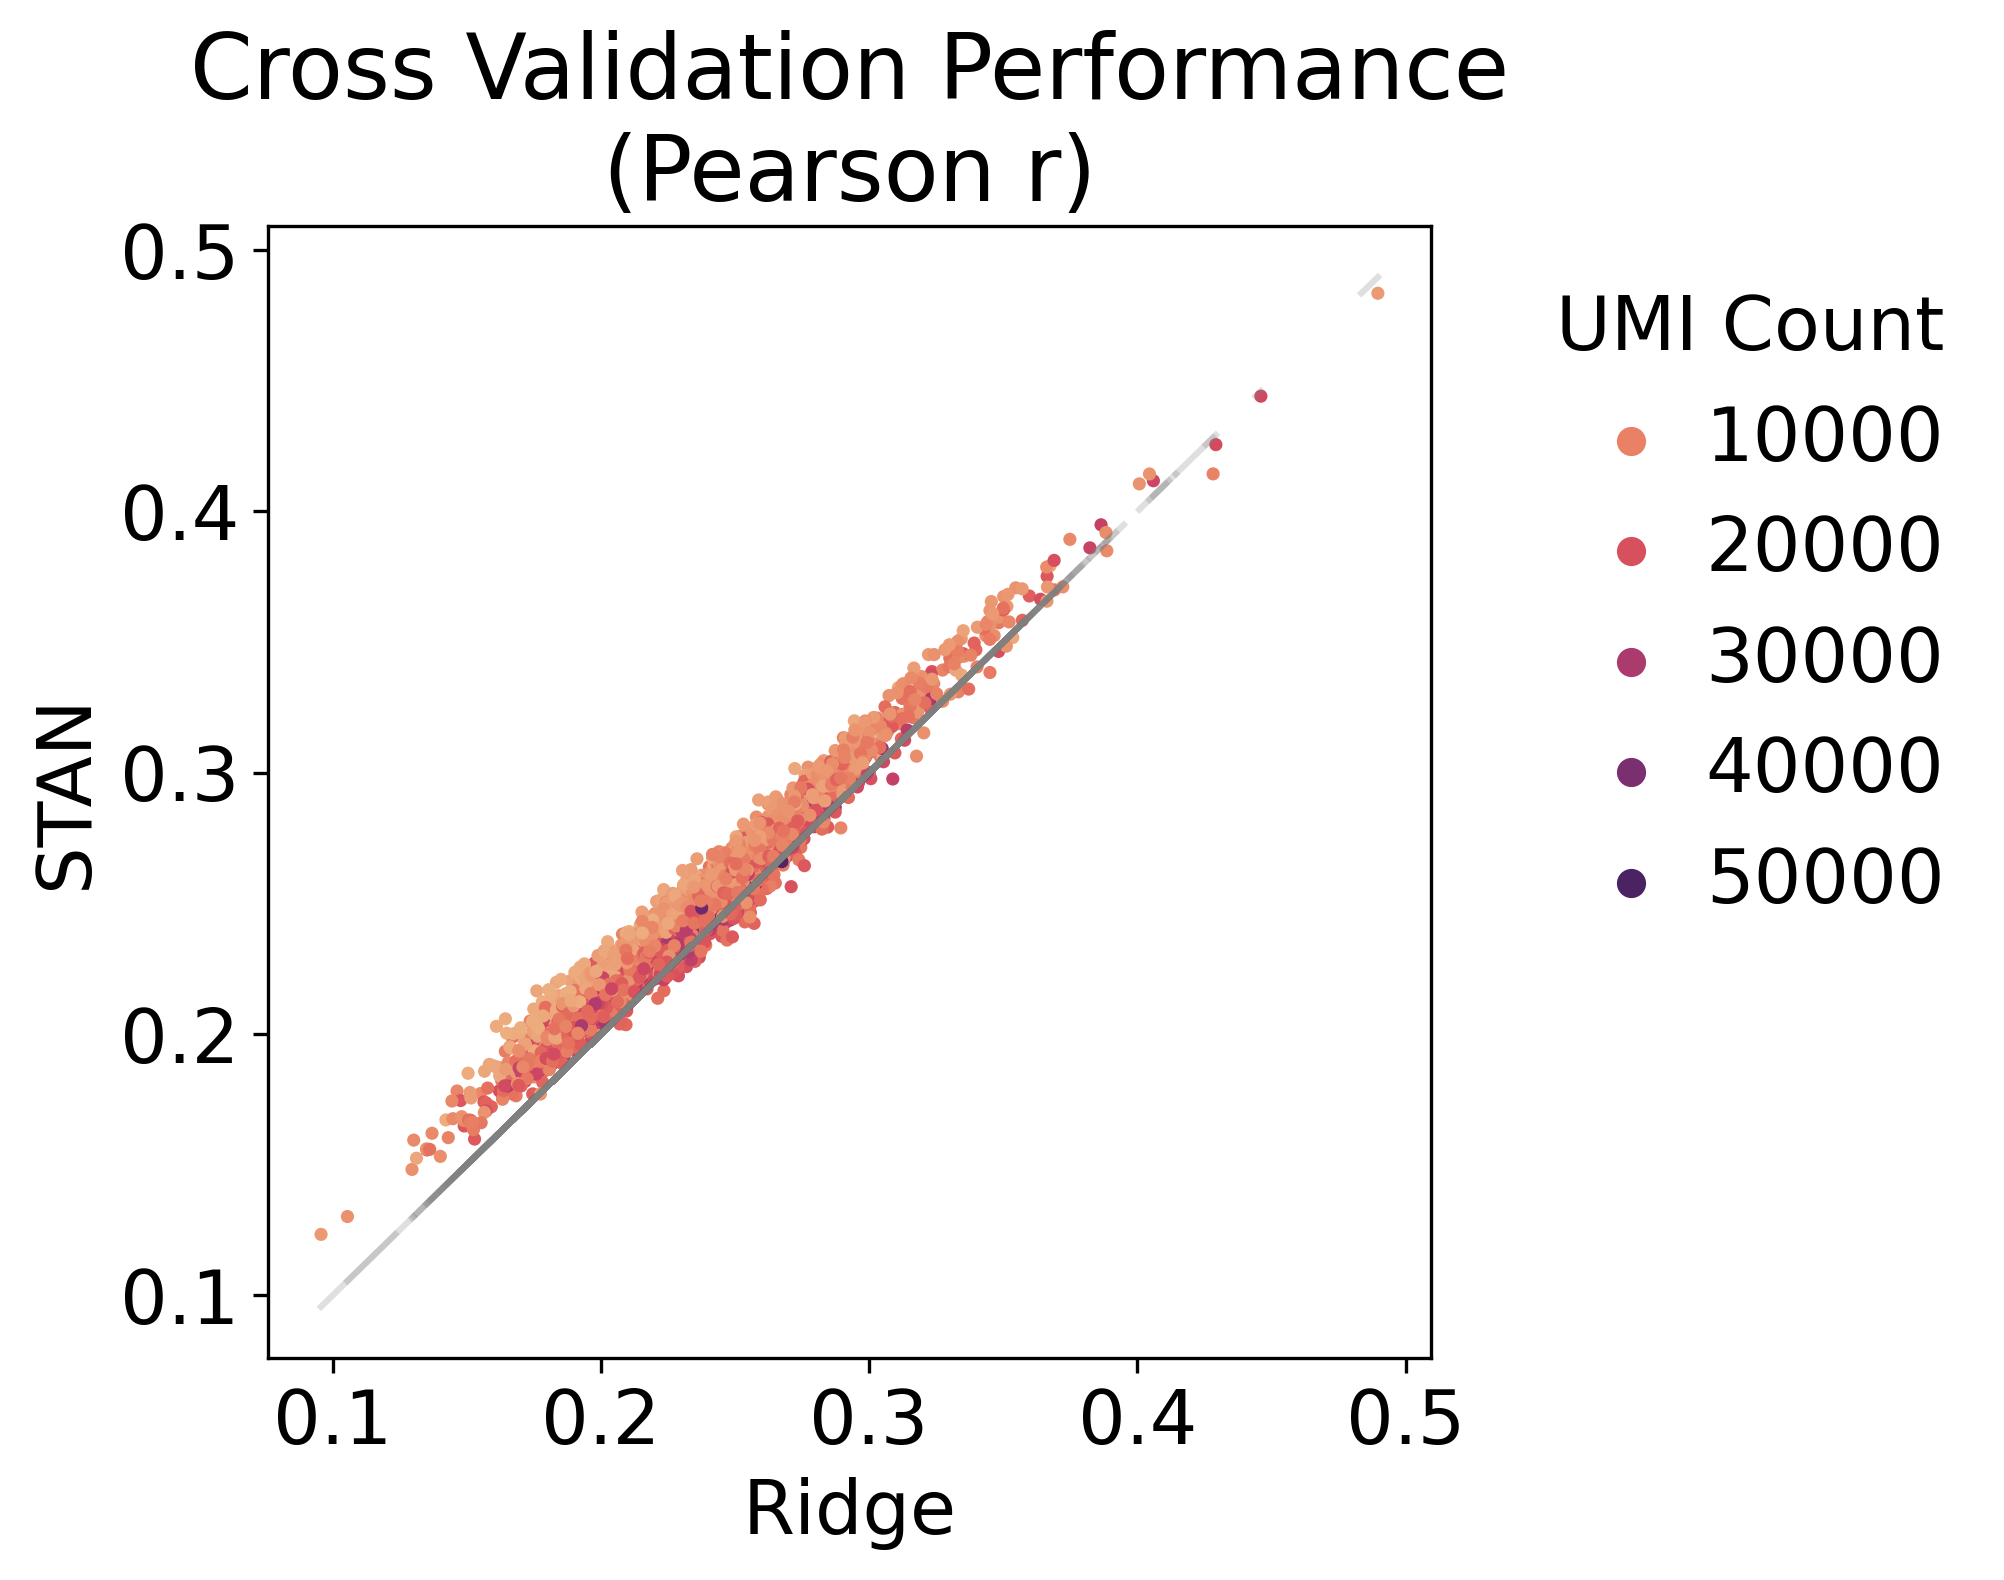

In [20]:
aux.plot_validation(adata_stan)

### Statistics

In [21]:
wilcoxon(adata_stan.obs["pred_cor_stan"], adata_stan.obs["pred_cor_ridge"], 
         zero_method='wilcox', correction=False, alternative='greater')

WilcoxonResult(statistic=5944160.0, pvalue=0.0)

In [22]:
pearsonr(adata_stan.obs["pred_cor_stan"]-adata_stan.obs["pred_cor_ridge"],
         adata_stan.obs["n_counts"])

PearsonRResult(statistic=-0.44758432784033747, pvalue=3.2738644053124675e-170)

## Embedding and Clustering

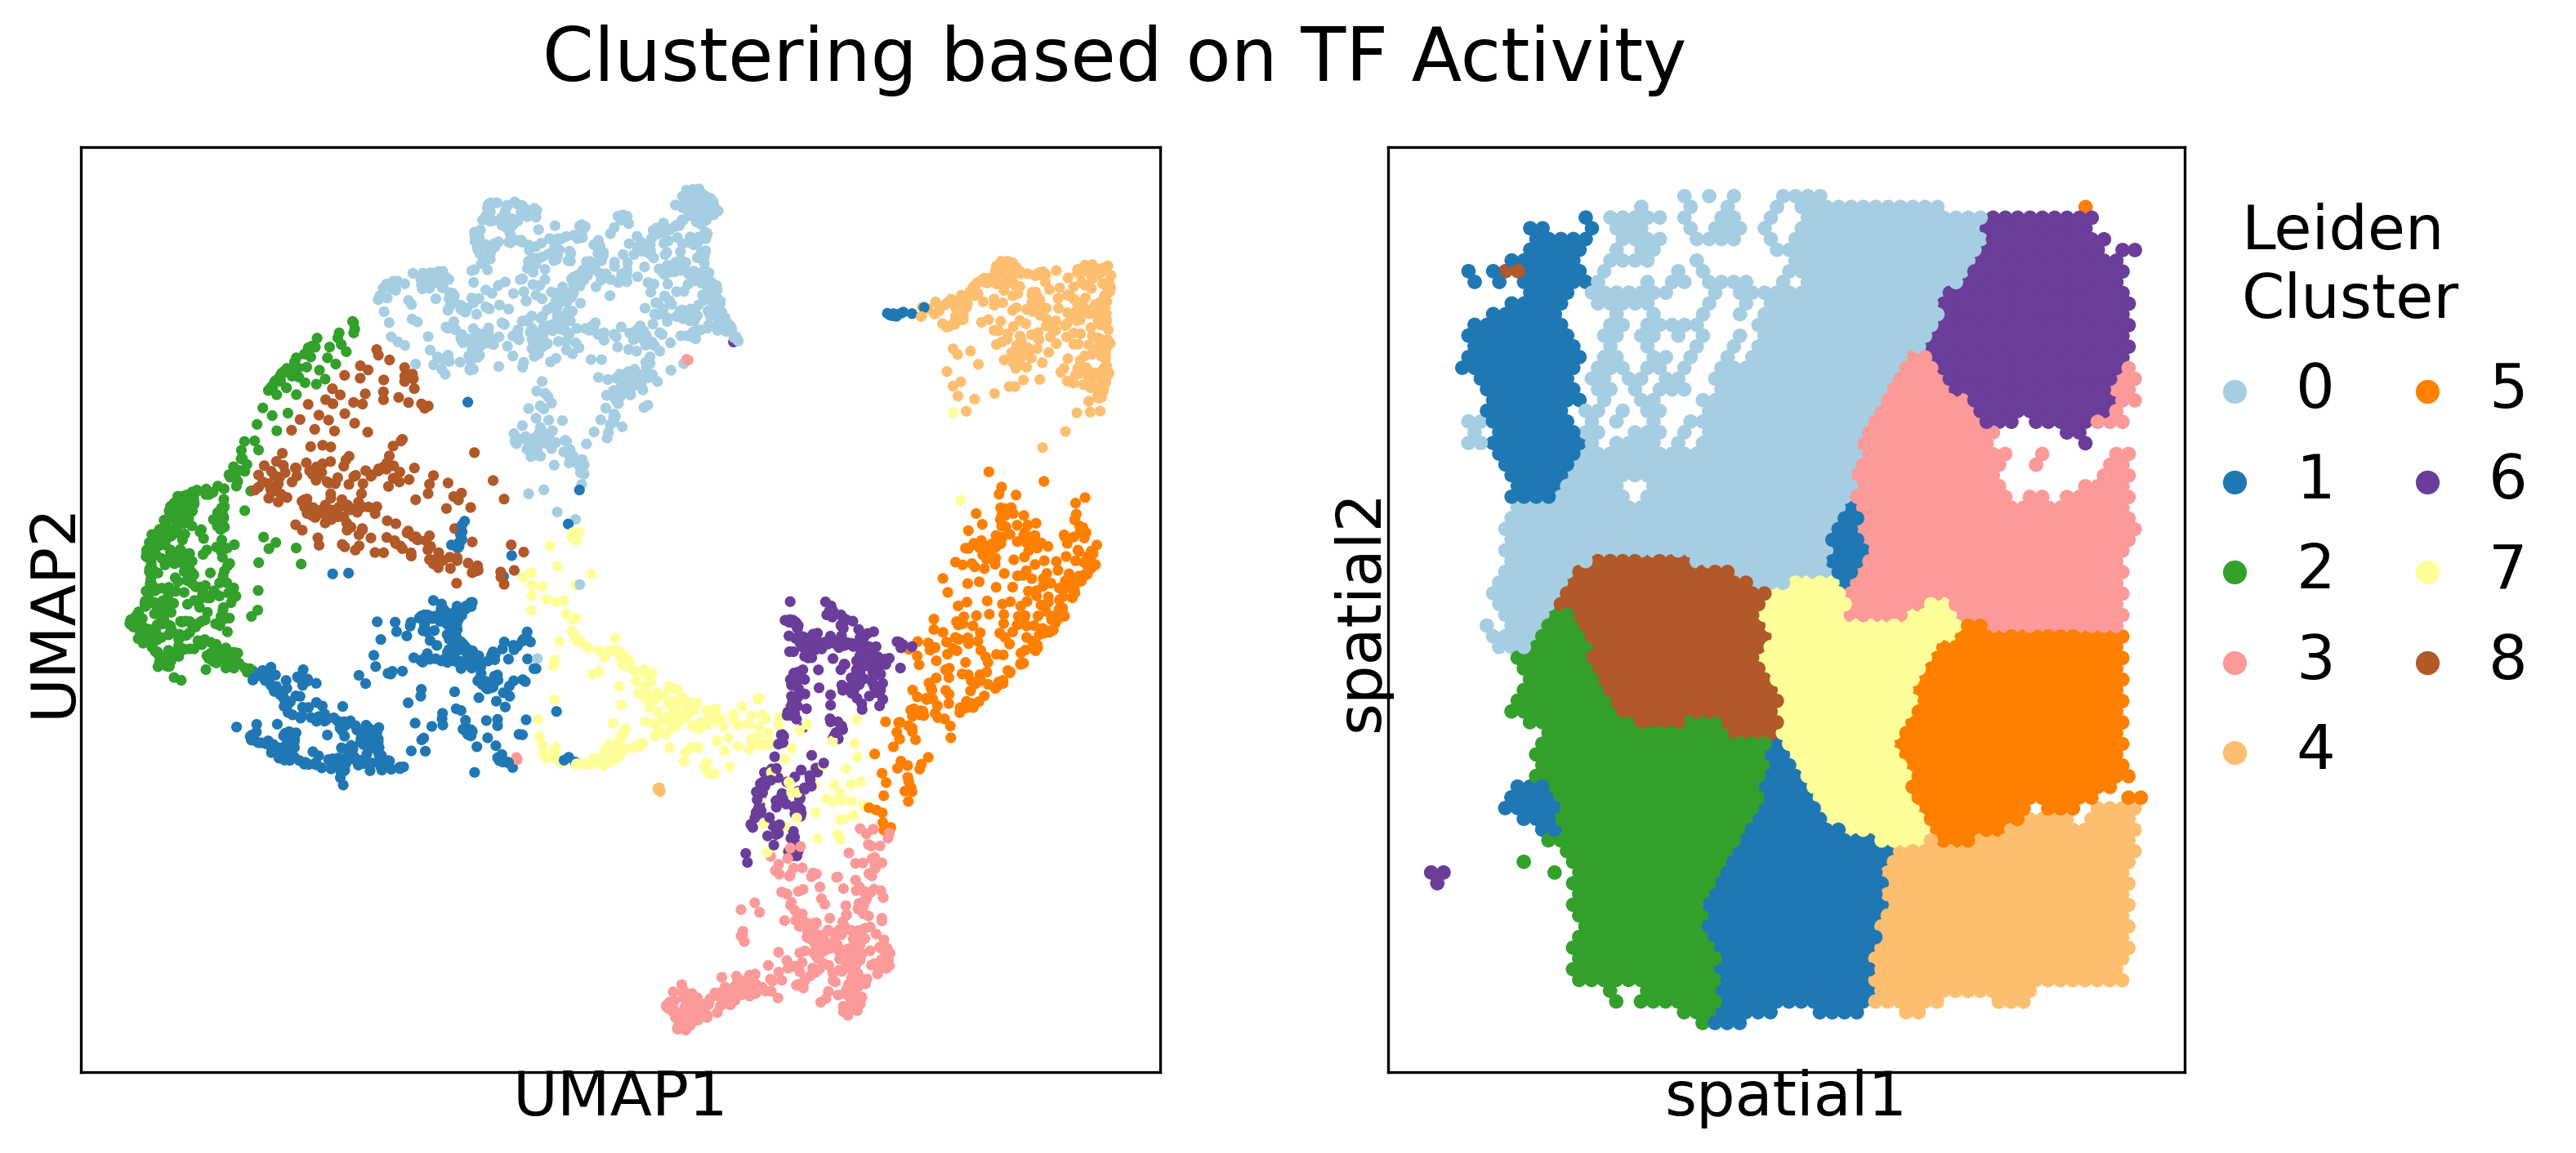

In [23]:
adata_tfa_scaled = adata_tfa.copy()
sc.pp.scale(adata_tfa_scaled)
sc.pp.neighbors(adata_tfa_scaled, use_rep='X', n_neighbors=100)
sc.tl.umap(adata_tfa_scaled, min_dist=0.01)
sc.tl.leiden(adata_tfa_scaled, resolution=0.55)
aux.plot_umap(adata_tfa_scaled, palette='Paired')

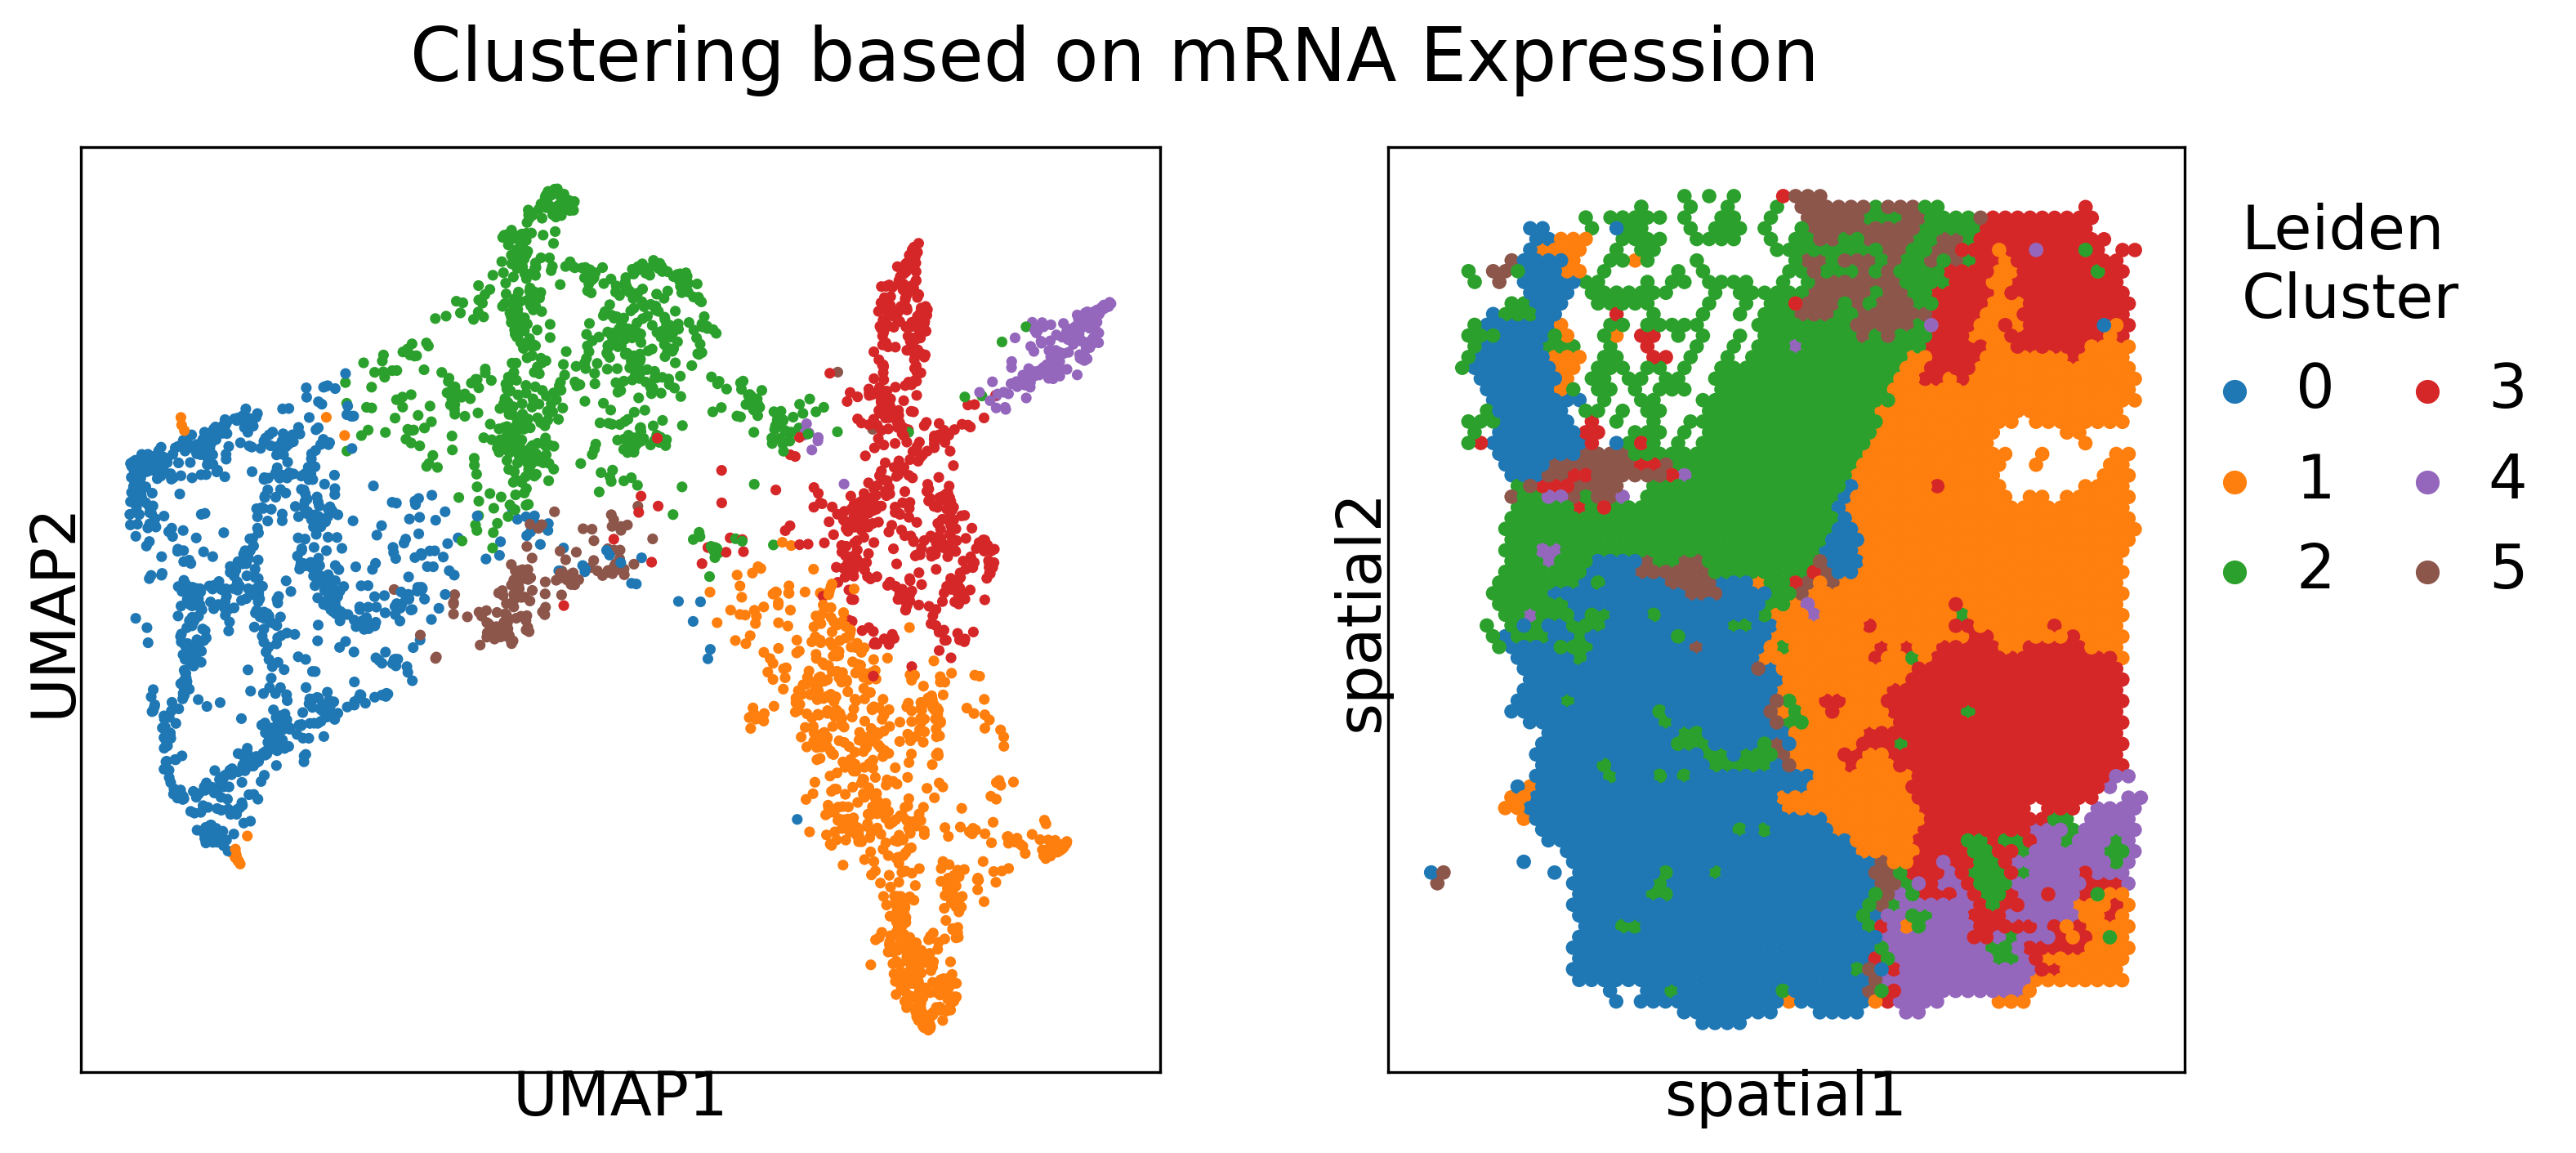

In [24]:
sc.pp.neighbors(adata_raw, use_rep='X', n_neighbors=100)
sc.tl.umap(adata_raw, min_dist=0.01)
sc.tl.leiden(adata_raw, resolution=0.4)
aux.plot_umap(adata_raw, palette=None, is_tf=False)

## Correlating TFs and genes
We obtained a list of human ligand-receptor interaction pairs from the [CellTalkDB](https://academic.oup.com/bib/article/22/4/bbaa269/5955941) [database](https://github.com/ZJUFanLab/CellTalkDB/tree/master/database), which includes 3,398 available ligand-receptor interaction pairs from among 815 ligands and 780 receptors. We have converted the rds file to csv.

In [25]:
df_lr_pair = pd.read_csv('resources_stan/human_lr_pair.csv', index_col=0)
ligand_list = list(set(df_lr_pair['ligand_gene_symbol']))
ligand_list = np.intersect1d(adata_raw.var_names, ligand_list).tolist()
receptor_list = list(set(df_lr_pair['receptor_gene_symbol']))
receptor_list = np.intersect1d(adata_raw.var_names, receptor_list).tolist()

mat_tf = adata_tfa.to_df()
tf_list = mat_tf.columns

In [26]:
mat_tf.head()

,AHR,AR,ARID3A,ARNT,ARNTL,ASCL1,ASCL2,ATF1,ATF2,ATF3,...,ZNF143,ZNF217,ZNF236,ZNF250,ZNF263,ZNF281,ZNF384,ZNF711,ZNF76,ZNF84
AAACAAGTATCTCCCA-1,-0.153569,-0.025570,-0.000631,-0.000153,-0.023796,0.005584,0.013191,-0.029685,0.018642,0.030031,...,0.003612,-0.328524,-0.008492,-0.167368,-0.006572,0.148893,-0.000874,-0.371695,-0.022740,-0.118797
AAACAATCTACTAGCA-1,-0.140108,-0.054283,-0.008828,0.019677,-0.031884,0.002259,0.014263,-0.032812,0.030609,0.011521,...,-0.006018,-0.294572,-0.053235,-0.091601,0.025818,0.059836,-0.004233,-0.262084,-0.034962,-0.212311
AAACACCAATAACTGC-1,-0.153189,-0.085405,-0.017764,0.050355,-0.045234,-0.028995,0.017683,-0.015596,0.062814,0.019735,...,0.009421,-0.157951,-0.110490,-0.074308,0.003845,0.185114,0.007966,-0.323579,-0.066916,-0.002893
AAACAGAGCGACTCCT-1,-0.123857,-0.051849,0.005952,0.032311,-0.050785,-0.015579,0.018016,-0.027924,0.047035,0.019257,...,0.010267,-0.228749,-0.080611,-0.141109,-0.007116,0.060903,-0.006143,-0.298113,-0.049849,-0.093687
AAACAGTGTTCCTGGG-1,-0.132556,-0.075864,0.001692,-0.003257,-0.051181,-0.007368,0.004318,-0.033083,0.039826,0.015781,...,0.006515,-0.260048,-0.041483,-0.108949,0.009538,0.134339,-0.014284,-0.183170,-0.049182,-0.218193


In [27]:
mat_ligand_neighbor = aux.compute_spatial_expression(adata_raw, df_lr_pair, 'ligand_gene_symbol')
mat_receptor_neighbor = aux.compute_spatial_expression(adata_raw, df_lr_pair, 'receptor_gene_symbol')

### Compute pairwise correlations
The step is slow. We use a subset of the lists.

In [28]:
ligand_list = ['ADM', 'PON2', 'VEGFA', 'VIM']
receptor_list = ['CD44', 'CD63', 'CD74', 'CD81', 'CSF1R', 'DDR1', 'EDNRB', 'ENG', 'FGFR3', 
                 'GPC1', 'GPR37L1', 'ITGAV', 'KCNJ10', 'LGR6', 'LIFR', 'MAGED1', 'PLAUR', 'PTPRZ1', 'RACK1']
tf_list = ['EPAS1', 'LHX2', 'MAFK', 'MAZ', 'PPARG', 'SOX2']

### Ligand-receptor correlation

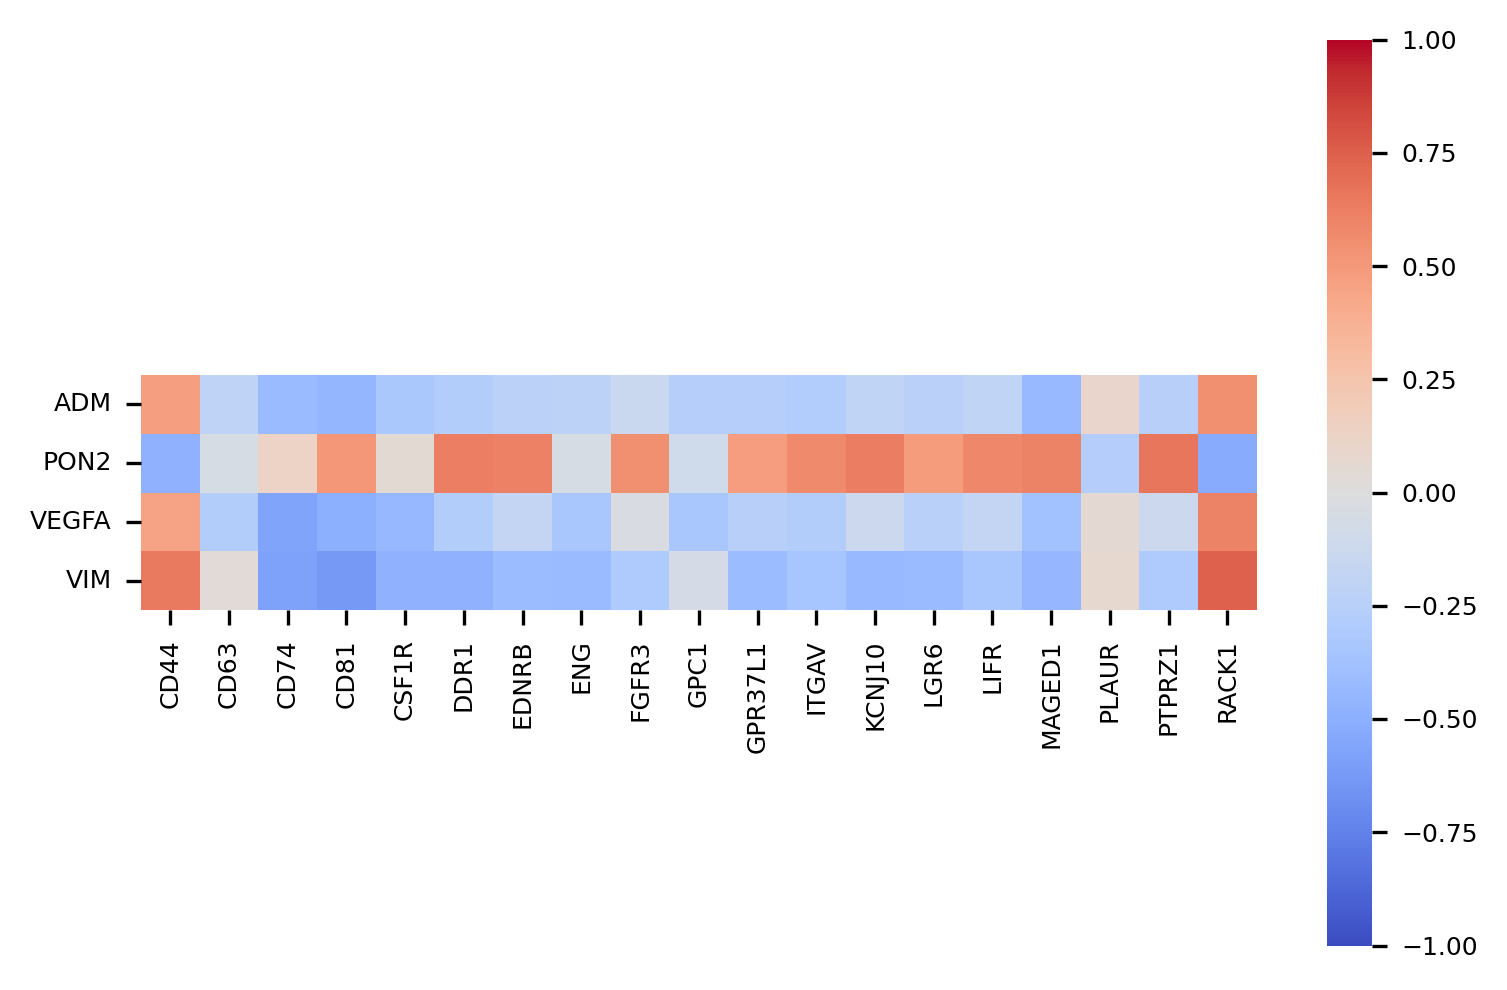

In [29]:
mat_corr_lr = pd.DataFrame({x: mat_ligand_neighbor[ligand_list].corrwith(mat_receptor_neighbor[x]) for x in receptor_list})
plt.figure(dpi=300)
plt.rc('font', size=6)
ax = sns.heatmap(mat_corr_lr, square=True, cmap="coolwarm", center=0, vmax=1, vmin=-1)

### TF-ligand correlation

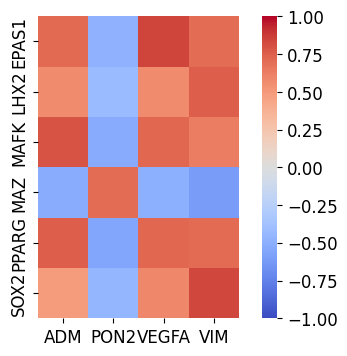

In [30]:
mat_corr_tl = pd.DataFrame({x: mat_tf[tf_list].corrwith(mat_ligand_neighbor[x]) for x in ligand_list})
plt.figure(dpi=100)
plt.rc('font', size=12)
ax = sns.heatmap(mat_corr_tl, square=True, cmap="coolwarm", center=0, vmax=1, vmin=-1)

### TF-receptor correlation

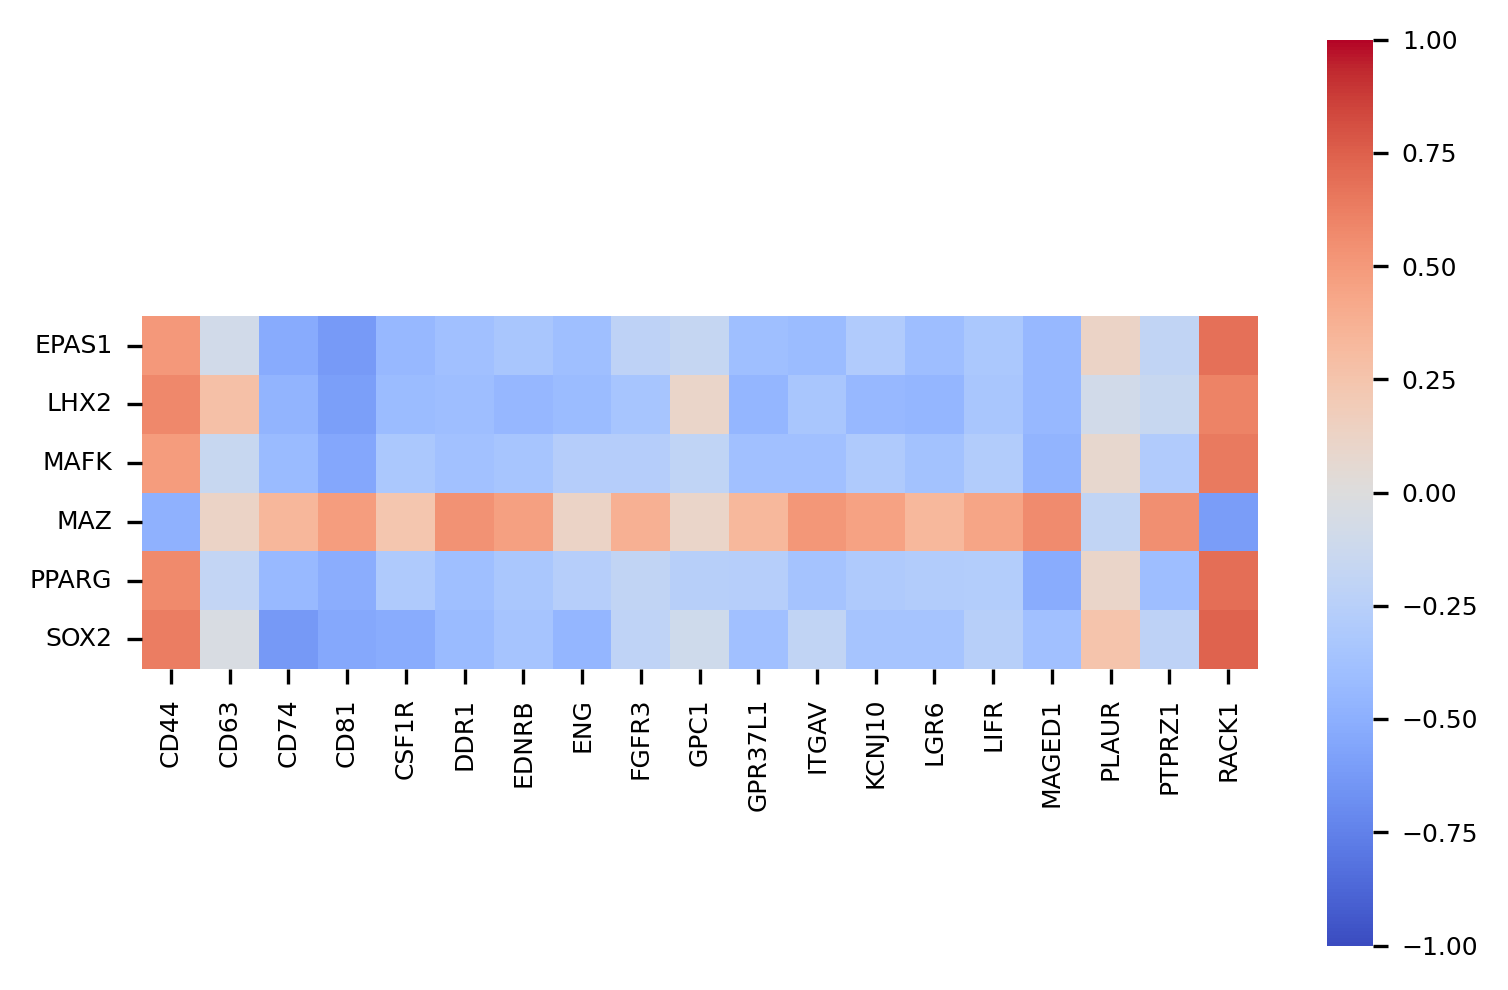

In [31]:
mat_corr_tr = pd.DataFrame({x: mat_tf[tf_list].corrwith(mat_receptor_neighbor[x]) for x in receptor_list})
plt.figure(dpi=300)
plt.rc('font', size=6)
ax = sns.heatmap(mat_corr_tr, square=True, cmap="coolwarm", center=0, vmax=1, vmin=-1)

### Spatial plots of ligands, TFs, and receptors

In [32]:
def plot_spatial_map(adata_raw, adata_tfa, tf, ligand, receptor):
    adata = adata_raw.copy()
    sc.pp.sqrt(adata)
    
    fig, axs = plt.subplots(1,3, figsize=(figsize*3, figsize), dpi=100)
    plt.rc('font', size=fontsize)
    sc.pl.spatial(adata, color=ligand, alpha_img=0, ax=axs[0],show=False, cmap="viridis", 
                  legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata_tfa, color=tf, alpha_img=0, ax=axs[1],show=False, cmap="plasma", 
                  legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata, color=receptor, alpha_img=0, ax=axs[2],show=False, cmap="viridis", 
                  legend_fontsize=fontsize, size=1.8)
    axs[0].set_title(receptor + ' mRNA expr', fontsize=fontsize)
    axs[1].set_title(tf + ' activity', fontsize=fontsize)
    axs[2].set_title(ligand + ' mRNA expr', fontsize=fontsize)
    
    for i in range(3):
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")

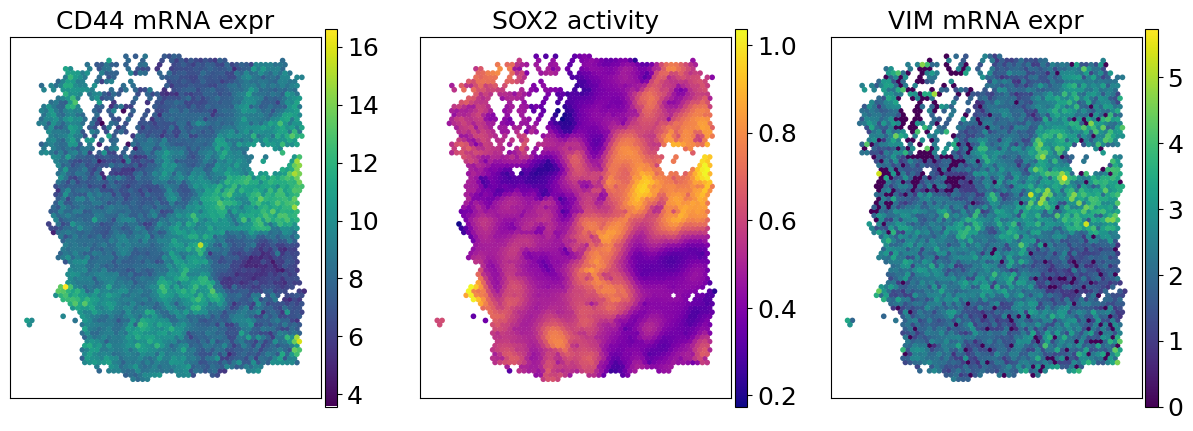

In [33]:
plot_spatial_map(adata_raw, adata_tfa, 'SOX2', 'VIM', 'CD44')